In [1]:
import pandas as pd
import numpy as np
import h5py
import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors
import seaborn as sns
from scipy.signal import savgol_filter
from scipy.signal import find_peaks

from scipy import signal
from scipy.optimize import curve_fit
from scipy import stats
from numpy.polynomial.polynomial import polyval

plt.style.use('seaborn')
%matplotlib inline
sns.set()

In [2]:
def spec_fit(x, c0, c1, c2, c3, w1, w2, f1):
    '''
    A function for fitting peaks to spectra.
    This fit function was copy-pasted in as text from David's fit function on 5/11/21.
    There are two water peaks (free water and bound water) modeled as gaussian peaks w1 and w2.
    There is the f1 fatty acid peak.
    There is a three-term polynomial function.

    :param x: input data
    :param c0: polynomial term 1
    :param c1: polynomial term 2
    :param c2: polynomial term 3
    :param c3: polynomial term 4
    :param w1: water peak term 1
    :param w2: water peak term 2
    :param f1: fatty acid peak
    :return:
    '''

    f_of_x = c0+c1*(x-1700)+c2*(x-1700)**2+c3*(x-1700)**3 + \
             w1*(0.0751747*np.exp(-(x-1903.82)**2/26.4725**2)+0.225213*np.exp(-(x-1942.21)**2/48.8781**2) +
                 0.005*np.exp(-(x-1779.71)**2/32.1869**2))/7.715 + \
             w2*(0.0280945*np.exp(-(x-1913.6)**2/25.0449**2)+0.103527*np.exp(-(x-1949.5)**2/52.2024**2))/3.07 + \
             f1*(0.31*np.exp(-(x-(1730-24))**2/17**2)+np.exp(-(x-1730)**2/17**2)+0.39 *
                 np.exp(-(x-(1730+31))**2/17**2))/25.484
    return f_of_x

def model_fit(df, wave_array):
    '''
    Performs spec_fit function on the input spectra.

    Input parameters:
    df is dataframe containing only the spectra, without extraneous columns
    wave_array is np.array containing the wavelengths of spectra

    Return values:
    modelparams is np.array of parameters output from curve_fit
    modelcovar is np.array of covariance array output from curve_fit
    modeled_spectra is np.array of the modeled spectra using the curve_fit parameters
    residual_spectra is np.array of the original spectrum - the modeled spectrum

    '''
    number = df.shape[0]
    modelparams = np.empty((number, 7), dtype=float)
    modelcovar = np.empty((number, 7, 7), dtype=float)
    modeled_spectra = np.empty((number, wave_array.shape[0]), dtype=float)
    residual_spectra = np.empty((number, wave_array.shape[0]), dtype=float)
    for i in range(number):
        row = df.iloc[i, :]
        modeled, pcov = curve_fit(spec_fit, wave_array, row)
        modelparams[i, :] = modeled
        modelcovar[i, ::] = pcov
        modeled_spectra[i, :] = spec_fit(wave_array, *modeled)
        residual_spectra[i, :] = row - modeled_spectra[i, :]
    return modelparams, modelcovar, modeled_spectra, residual_spectra


def extract_farray(modelparams):
    '''
    Convenience function to create an np.array containing only the f1 values

    Input:  the modelparams np.array created by model_fit().
    '''
    return modelparams[:, 6]


def create_modelparams_df(modelparams):
    columns = ['c0', 'c1', 'c2', 'c3', 'w1', 'w2', 'f1']
    modelparams_df = pd.DataFrame(data=modelparams, columns=columns)
    return modelparams_df


def extract_f_sd_err(modelcovar):
    '''
    Convenience function to create an np.array containing the standard deviation
       of the covariance matrix for the f1 term.

    Input:  the modelcovar np.array created by model_fit().

    '''
    f_sd_err = np.empty(modelcovar.shape[0])
    for i in range(modelcovar.shape[0]):
        f_sd_err[i] = np.diag(modelcovar[i, :, :])[6]
    return f_sd_err


def high_f1_numbers(farray, threshold):
    '''
    Returns np.array of the index positions of spectra with f1 values greater than the
       threshold.  Use this with iloc to find the appropriate rows in the dataframe.

    Input:  np.array output from extract_farray() and desired threshold value.
    '''
    return np.where(farray > threshold)[0]


def get_visible_wavelength_vector(file_path, calibration_path_str):
    with h5py.File(file_path, 'r') as h5_file:
        wavelength_vector = h5_file[calibration_path_str].attrs['spec1_wavelengths_vector'][:]
        return wavelength_vector


def get_visible_insertion_absorbance_depth_df(file_path, insertion_path_str):
    with h5py.File(file_path, 'r') as h5_file:
        absorbance_depth = h5_file[f"{insertion_path_str}/derived/absorbance_depth"][:]
        calibration_path_str = insertion_path_str[:17]
        wavelength_vector = h5_file[calibration_path_str].attrs['spec1_wavelengths_vector'][:]
        length = wavelength_vector.shape[0]
        columns = list(np.arange(0, length, 1))
        columns.append('force')
        columns.append('depth')
        dataframe = pd.DataFrame(data=absorbance_depth, columns=columns)
        return dataframe


def create_insertions_date_dataframe(spreadsheet, date_selection):
    df = pd.read_csv(spreadsheet)
    selected_df = df.loc[df['date'] == date_selection]
    return selected_df

In [3]:
df = pd.read_csv('data/Schnieder park spectra_2020_edited.csv', index_col=0)
waves = np.arange(1550, 1951, 5)

all_values_df = df[['insertion', 'depth']].copy()
absorbances = df.iloc[:, 2:].copy()
modelparams, modelcovar, modeled_spectra, residual_spectra = model_fit(absorbances, waves)
sd_err = extract_f_sd_err(modelcovar)
all_values_df['sd_err'] = sd_err
squared_errors = np.square(residual_spectra)
mse = np.mean(squared_errors, axis=1)
rmse = np.sqrt(mse)
all_values_df['rmse'] = rmse
all_values_df['rmse100'] = all_values_df['rmse'] * 100
farray = extract_farray(modelparams)
all_values_df[['c0', 'c1', 'c2', 'c3', 'w1', 'w2', 'f1']] = modelparams

In [4]:
all_values_df['f1'].describe()

count    43.000000
mean      0.215013
std       0.198302
min      -0.184293
25%       0.124136
50%       0.204170
75%       0.233154
max       1.080794
Name: f1, dtype: float64

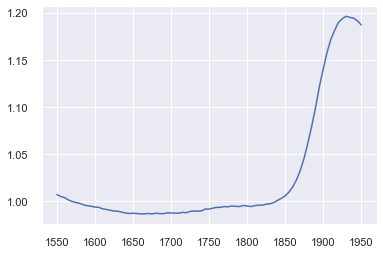

In [5]:
plt.plot(waves, absorbances.iloc[0, :])

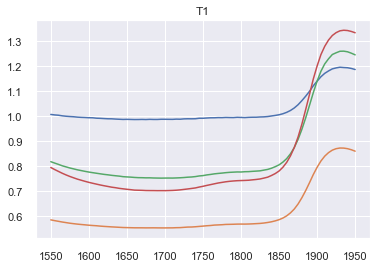

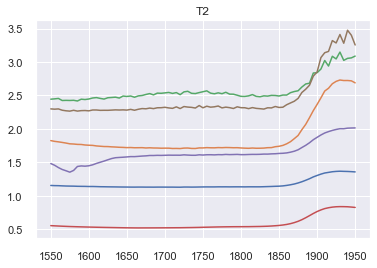

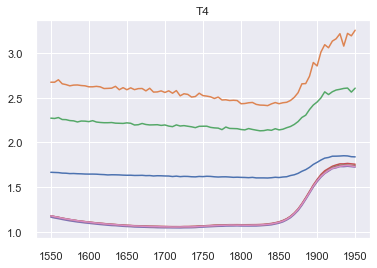

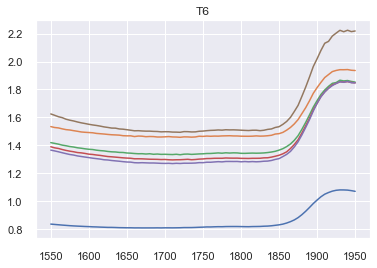

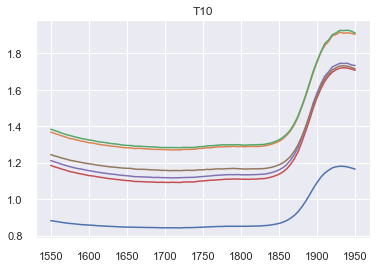

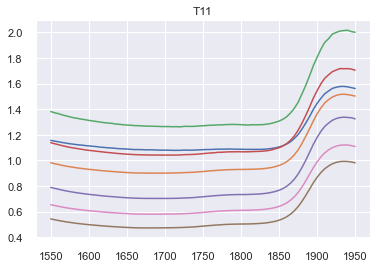

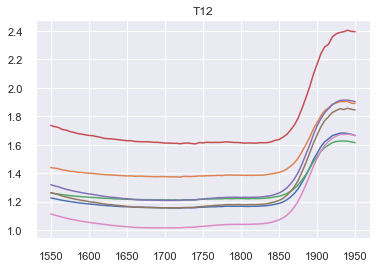

In [6]:
for insertion in df['insertion'].unique():
    fig, ax = plt.subplots()
    ax.set_title(insertion)
    ins_abs_df = df.loc[df['insertion'] == insertion]
    for i in range(ins_abs_df.shape[0]):
        ax.plot(waves, ins_abs_df.iloc[i, 2:])
    plt.show()
    plt.close()

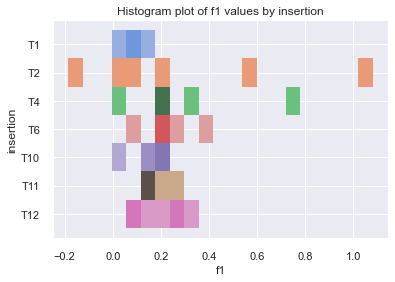

In [7]:
fig, ax = plt.subplots()
ax.set_title("Histogram plot of f1 values by insertion")
sns.histplot(data=all_values_df, x='f1', y='insertion', hue='insertion', legend=False);
plt.show()
plt.close()

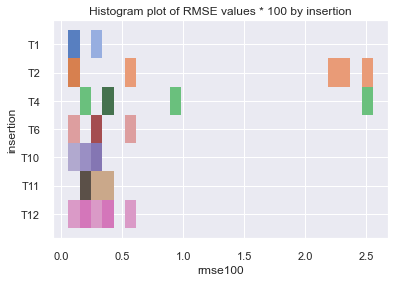

In [8]:
fig, ax = plt.subplots()
ax.set_title("Histogram plot of RMSE values * 100 by insertion")
sns.histplot(data=all_values_df, x='rmse100', y='insertion', hue='insertion', legend=False);
plt.show()
plt.close()

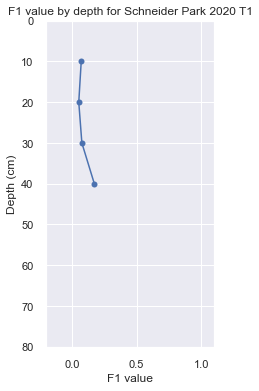

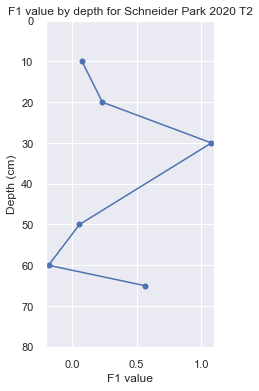

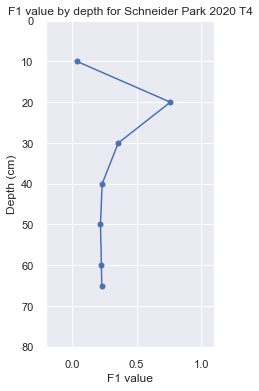

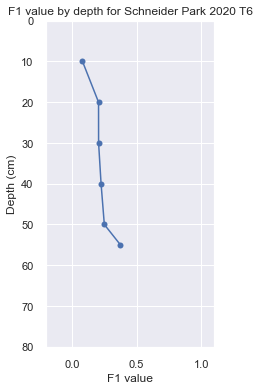

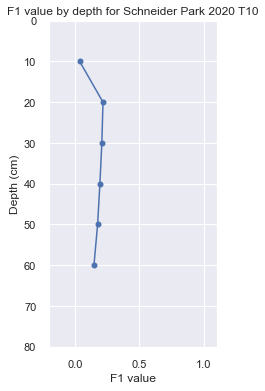

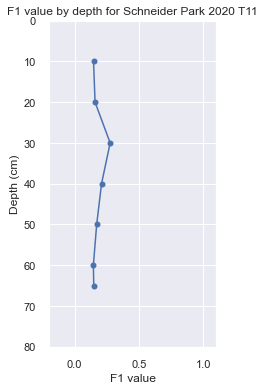

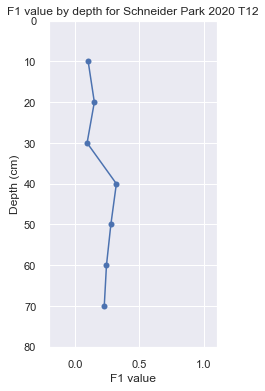

In [13]:
for insertion in all_values_df['insertion'].unique():
    plot_df = all_values_df.loc[all_values_df['insertion'] == insertion]
    fig, ax = plt.subplots(figsize=(3, 6))
    ax.set_title(f"F1 value by depth for Schneider Park 2020 {insertion}")
    ax.set_ylabel("Depth (cm)")
    ax.set_xlabel("F1 value")
    ax.set_ylim(80.0, 0.0)
    ax.set_xlim(-0.2, 1.1)
    ax.plot(plot_df['f1'], plot_df['depth'], '-o')
    plt.show()
    plt.close()

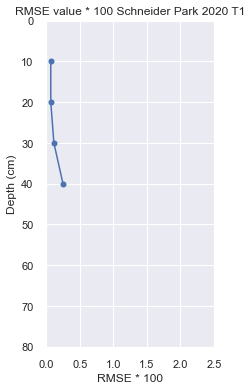

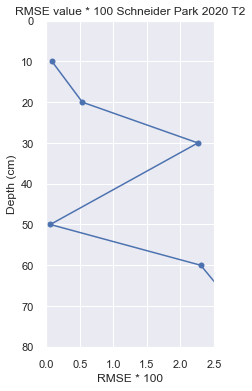

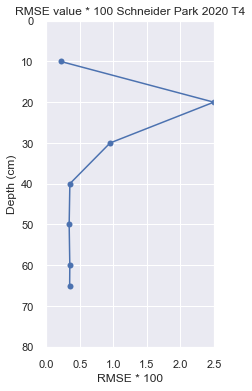

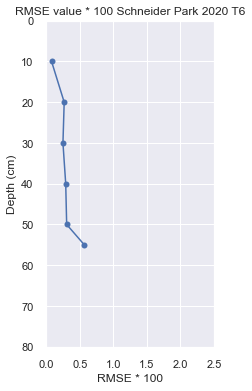

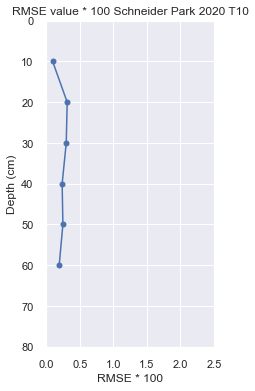

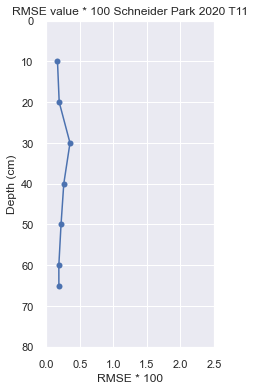

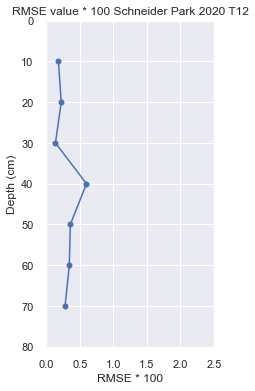

In [17]:
for insertion in all_values_df['insertion'].unique():
    plot_df = all_values_df.loc[all_values_df['insertion'] == insertion]
    fig, ax = plt.subplots(figsize=(3, 6))
    ax.set_title(f"RMSE value * 100 Schneider Park 2020 {insertion}")
    ax.set_ylabel("Depth (cm)")
    ax.set_xlabel("RMSE * 100")
    ax.set_ylim(80.0, 0.0)
    ax.set_xlim(0, 2.5)
    ax.plot(plot_df['rmse100'], plot_df['depth'], '-o')
    plt.show()
    plt.close()

In [18]:
t2_df = df.loc[df['insertion'] == 'T2']

In [19]:
all_values_df.iloc[4, :2]

insertion    T2
depth        10
Name: T2_10, dtype: object

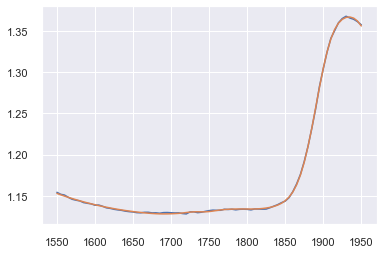

In [21]:
plt.plot(waves, df.iloc[4, 2:])
plt.plot(waves, modeled_spectra[4, :])

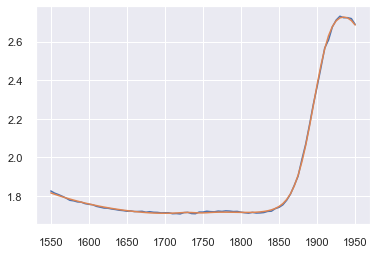

In [22]:
plt.plot(waves, df.iloc[5, 2:])
plt.plot(waves, modeled_spectra[5, :])

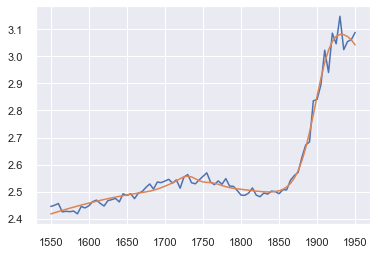

In [23]:
plt.plot(waves, df.iloc[6, 2:])
plt.plot(waves, modeled_spectra[6, :])

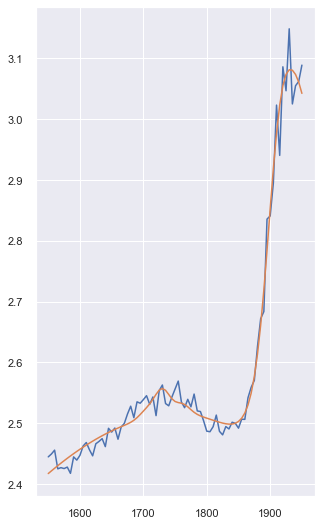

In [25]:
fig, ax = plt.subplots(figsize=(5, 9))
ax.plot(waves, df.iloc[6, 2:])
ax.plot(waves, modeled_spectra[6, :])
plt.show()
plt.close()